In [1]:
import pandas as pd
import numpy as np
import os
import glob

import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15, 5)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
from helpers import *

# Data prep

## ODB TSV

Data för 2011 - 2015

Läs in fil

In [3]:
df = pd.read_csv('../indata/ODB_TSV/ODB-Sysselsättning efter område, tid, ålder, sysselsättning och kön.txt', sep='\t', header=1)

Specificera indexering

In [4]:
df = df.set_index(['område', 'tid'])

Vänd ner samtliga kolumner i en kolumn

In [5]:
df = pd.DataFrame(df.stack())

Lyft ut index till kolumner igen

In [6]:
df = df.reset_index()

Sätt beskrivande kolumnnamn

In [7]:
df = df.rename(columns={'level_2': 'age_group_gender', 0: 'value', 'tid':'year'})

Splitta områdesnamn till endast baskod

In [8]:
df['område'] = df['område'].str.split(' ', 1, expand = True)
df = df.rename(columns={'område': 'BASKOD2010'})
df['BASKOD2010'] = df['BASKOD2010'].astype(str).astype(int)

Byt om `BASKOD2010` till entity-namnet

In [9]:
df = baskod2010tobasomrade(df)

Splitta ut `ageyeargender` till fyra separata kolumner

In [10]:
df['Kön'] = df['age_group_gender'].str.split().str[-1]

df['agegroup'] = df['age_group_gender'].str.split().str[0]

df['kategori'] = df['age_group_gender'].str.split().str[2:-1].str.join(' ')

Specificera ordningen på kolumnerna

In [11]:
df = df[['basomrade','year','kategori', 'Kön', 'agegroup', 'value']]

Specificera indexering

In [12]:
df = df.set_index(['basomrade'])

In [13]:
df = df.groupby(['basomrade', 'year', 'kategori', 'Kön']).sum().reset_index()

Sätt `Kön` till en pandas category

In [14]:
df['Kön'] = df['Kön'].astype('category')
df['Kön'].cat.categories = ['female', 'male']

## SCB CSV

Data för 2016

In [15]:
path = '../indata/supermappen/Tabell7A_ForvKonBas.csv'
df_csv = pd.read_csv(path,  encoding='latin1' , sep=';', decimal=',')

In [16]:
df_csv['year'] = 2016
df_csv = df_csv.rename(columns={
    'basomrade': 'BASKOD2010',
    'Forvkvinna': 'forv female',
    'ForvMan': 'forv male',
    'EjForvkvinna': 'ejforv female',
    'EjForvMan': 'ejforv male'
})

# from baskod to basomrade
df_csv = baskod2010tobasomrade(df_csv)

# drop irrelevant columns
df_csv = df_csv.drop(columns=['Totalt', 'BASKOD2010', 'BASKOD2000'])

# set index
df_csv = df_csv.set_index(['basomrade', 'year'])

# pivot columns into a single column
df_csv = pd.DataFrame(df_csv.stack()).reset_index()

# set column names
df_csv = df_csv.rename(columns={'level_2': 'group_gender', 0: 'value'})

# split group_gender into gender
df_csv['Kön'] = df_csv['group_gender'].str.split().str[-1]

# spllit group_gender into group
df_csv['kategori'] = df_csv['group_gender'].str.split().str[0]

# drop group_gender
df_csv = df_csv.drop(columns=['group_gender'])

# set gender column to type category
df_csv['Kön'] = df_csv['Kön'].astype('category')

In [17]:
# rename categories to match ODB TSV datasource
df_csv.loc[df_csv['kategori'] == 'forv', 'kategori'] = 'Förvärvsarbetande län 01'
df_csv.loc[df_csv['kategori'] == 'ejforv', 'kategori'] = 'Ej Förvärvsarbetande'

## Merge data sources

In [18]:
concat = pd.concat([df, df_csv], sort=False)

In [19]:
# df = concat

# Befolkning 20-64

In [20]:
concept = 'population_aged_20_64'

In [21]:
popgender = df.groupby(['basomrade', 'year', 'Kön']).sum().reset_index()
total = df.groupby(['basomrade', 'year']).sum().reset_index()

In [22]:
total = appendNewDatapoints(concept, total)
female, male = byGender(concept, popgender)

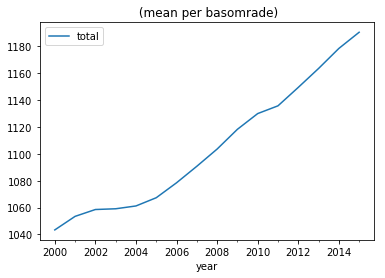

In [23]:
plotcombined(total, 'total')

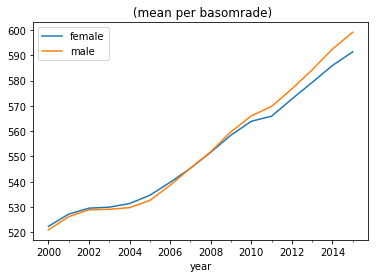

In [24]:
plotcombined(female, 'female')
plotcombined(male, 'male')